# Feature Overview
To demonstrate our features, we will use a ML pipeline from the healthcare domain. The pipeline is from the [mlinspect](https://www.github.com/stefan-grafberger/mlinspect) project. It predicts which patients are at a higher risk of serious complications, under the requirement to achieve comparable false negative rates across intersectional groups by age and race. The pipeline is implemented using native constructs from the popular pandas and scikit-learn libraries.

```python
import ...

COUNTIES_OF_INTEREST = ['county2', 'county3']

patients = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
                                    "patients.csv"), na_values='?')
histories = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
                                     "histories.csv"), na_values='?')

data = patients.merge(histories, on=['ssn'])
complications = data.groupby('age_group') \
    .agg(mean_complications=('complications', 'mean'))
data = data.merge(complications, on=['age_group'])
data['label'] = data['complications'] > 1.2 * data['mean_complications']
data = data[['smoker', 'last_name', 'county', 'num_children', 'race', 'income', 'label']]
data = data[data['county'].isin(COUNTIES_OF_INTEREST)]

impute_and_one_hot_encode = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
featurisation = ColumnTransformer(transformers=[
    ("impute_and_one_hot_encode", impute_and_one_hot_encode, ['smoker', 'county', 'race']),
    ('word2vec', MyW2VTransformer(min_count=2), ['last_name']),
    ('numeric', StandardScaler(), ['num_children', 'income']),
], remainder='drop')
neural_net = MyKerasClassifier(build_fn=create_model, epochs=10, batch_size=1, verbose=0)
pipeline = Pipeline([
    ('features', featurisation),
    ('learner', neural_net)])

train_data, test_data = train_test_split(data)
model = pipeline.fit(train_data, train_data['label'])
print("Mean accuracy: {}".format(model.score(test_data, test_data['label'])))
```

To now conduct our what-if analyses, we do not need to rewrite this pipeline file, we can use it directly as input for mlwhatif.

In [1]:
import os
from example_pipelines import HEALTHCARE_PY
from example_pipelines.healthcare import custom_monkeypatching
from mlwhatif import PipelineAnalyzer
from mlwhatif.analysis._data_corruption import DataCorruption, CorruptionType
from mlwhatif.utils import get_project_root
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL) #Supress default INFO logging

DEMO_PY = os.path.join(str(get_project_root()), "demo", "feature_overview", "healthcare.py")

data_corruption = DataCorruption([('income', CorruptionType.SCALING),
                                  ('num_children', CorruptionType.MISSING_VALUES)],
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=True)

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .execute()

report = analysis_result.analysis_to_result_reports[data_corruption]

2022-10-12 13:46:10.559089: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 13:46:10.651008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Let us start by looking at the report generated by the analysis.

In [2]:
report

column  corruption_percentage  accuracy_score_corrupt_test_only_L57  \
0          None                    NaN                              0.890411   
1        income                    0.3                              0.767123   
2        income                    0.6                              0.561644   
3        income                    0.9                              0.452055   
4  num_children                    0.3                              0.794521   
5  num_children                    0.6                              0.630137   
6  num_children                    0.9                              0.520548   

   accuracy_score_corrupt_train_and_test_L57  \
0                                   0.890411   
1                                   0.726027   
2                                   0.506849   
3                                   0.438356   
4                                   0.931507   
5                                   0.917808   
6                                   0.931507   

           false_negative_rate_corrupt_test_only_L61  \
0  <fairlearn.metrics._metric_frame.MetricFrame o...   
1  <fairlearn.metrics._metric_frame.MetricFrame o...   
2  <fairlearn.metrics._metric_frame.MetricFrame o...   
3  <fairlearn.metrics._metric_frame.MetricFrame o...   
4  <fairlearn.metrics._metric_frame.MetricFrame o...   
5  <fairlearn.metrics._metric_frame.MetricFrame o...   
6  <fairlearn.metrics._metric_frame.MetricFrame o...   

      false_negative_rate_corrupt_train_and_test_L61  \
0  <fairlearn.metrics._metric_frame.MetricFrame o...   
1  <fairlearn.metrics._metric_frame.MetricFrame o...   
2  <fairlearn.metrics._metric_frame.MetricFrame o...   
3  <fairlearn.metrics._metric_frame.MetricFrame o...   
4  <fairlearn.metrics._metric_frame.MetricFrame o...   
5  <fairlearn.metrics._metric_frame.MetricFrame o...   
6  <fairlearn.metrics._metric_frame.MetricFrame o...   

   equalized_odds_difference_corrupt_test_only_L64  \
0                                         0.428571   
1                                         0.475000   
2                                         0.789474   
3                                         0.652778   
4                                         0.375000   
5                                         0.750000   
6                                         0.647727   

   equalized_odds_difference_corrupt_train_and_test_L64  
0                                           0.428571     
1                                           0.500000     
2                                           0.888889     
3                                           0.652778     
4                                           0.200000     
5                                           0.285714     
6                                           0.285714

To help us to understand what is going on, let us use some convenience functions to save the intermediate DAGs mlwhatif uses internally.

In [3]:
from mlwhatif.utils import get_project_root

CORRUPTION_INTERMEDIATE_EXTRACTION_ORIG_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                 "data_corruption-orig")
CORRUPTION_INTERMEDIATE_EXTRACTION_GENERATED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "data_corruption-what-if")
CORRUPTION_INTERMEDIATE_EXTRACTION_OPTIMISED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "data_corruption-what-if-optimised")

analysis_result.save_original_dag_to_path(CORRUPTION_INTERMEDIATE_EXTRACTION_ORIG_PATH)
analysis_result.save_what_if_dags_to_path(CORRUPTION_INTERMEDIATE_EXTRACTION_GENERATED_PATH)
analysis_result.save_optimised_what_if_dags_to_path(CORRUPTION_INTERMEDIATE_EXTRACTION_OPTIMISED_PATH)

Let us now look at the original pipeline DAG.

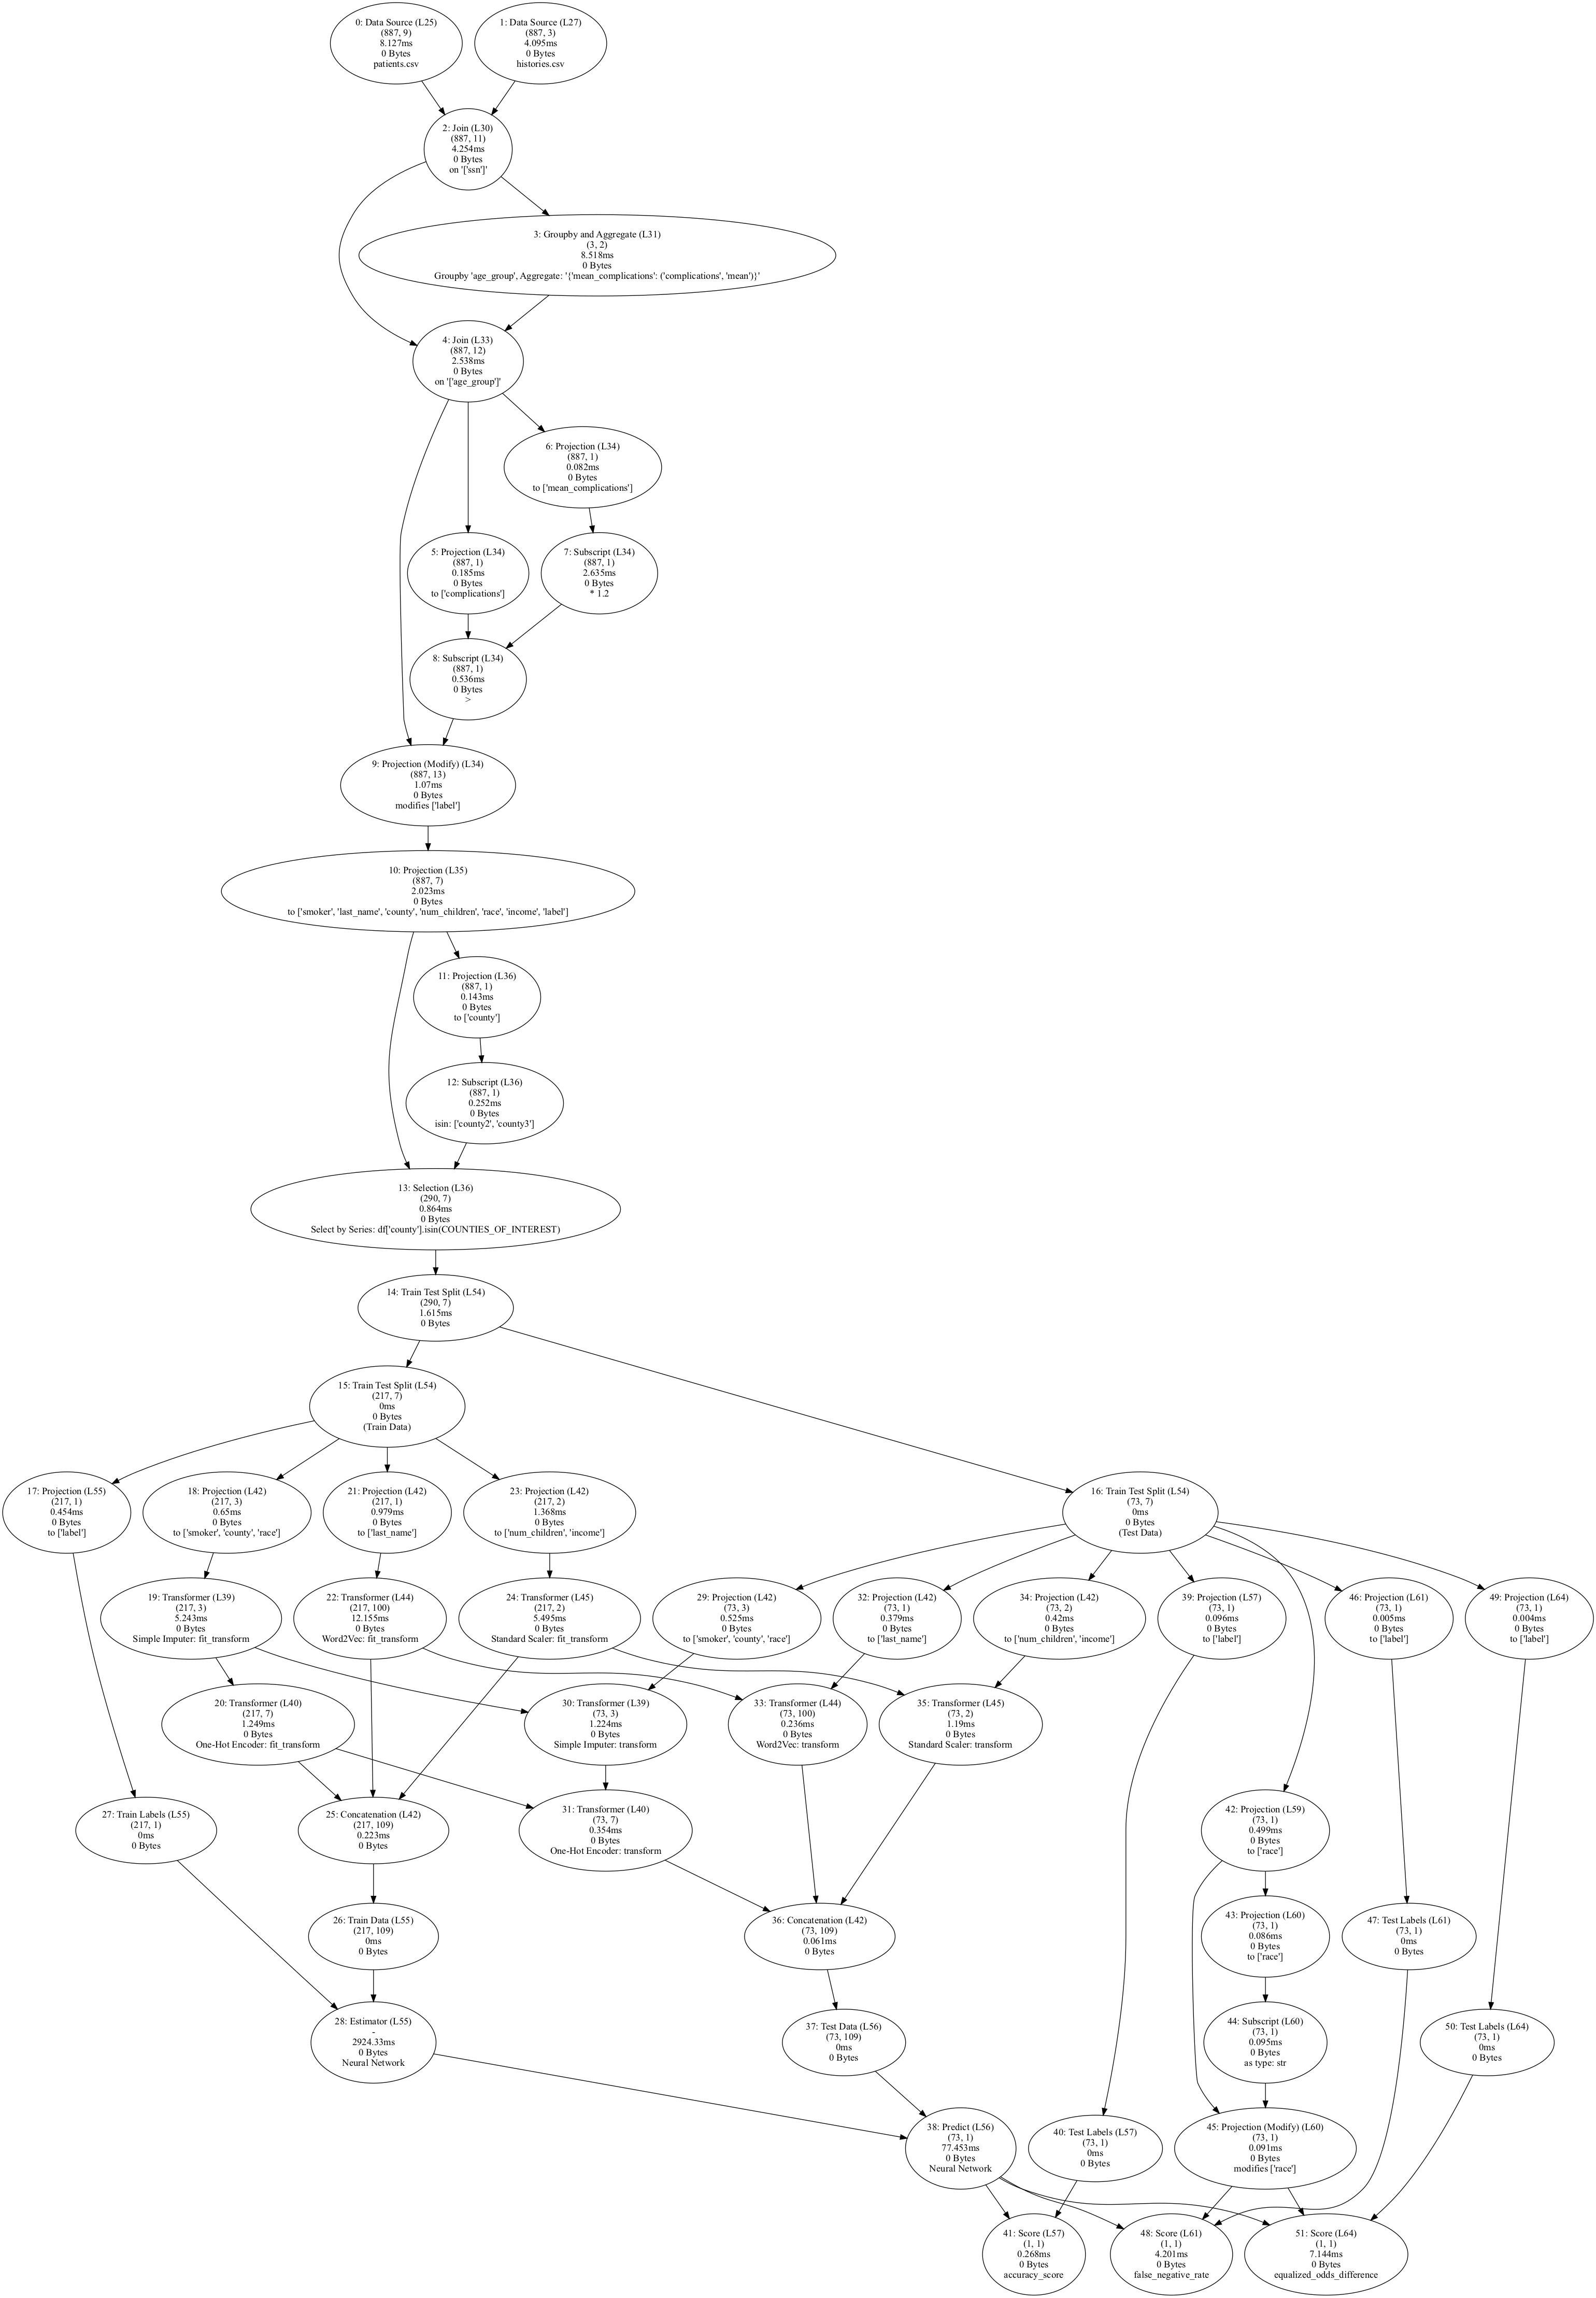

In [4]:
from IPython.display import Image
Image(filename=f"{CORRUPTION_INTERMEDIATE_EXTRACTION_ORIG_PATH}.png")

This pipeline DAG then gets rewritten to several DAGs we need for our analysis. Let us look at an example. Note the corruption operation now present in the DAG.

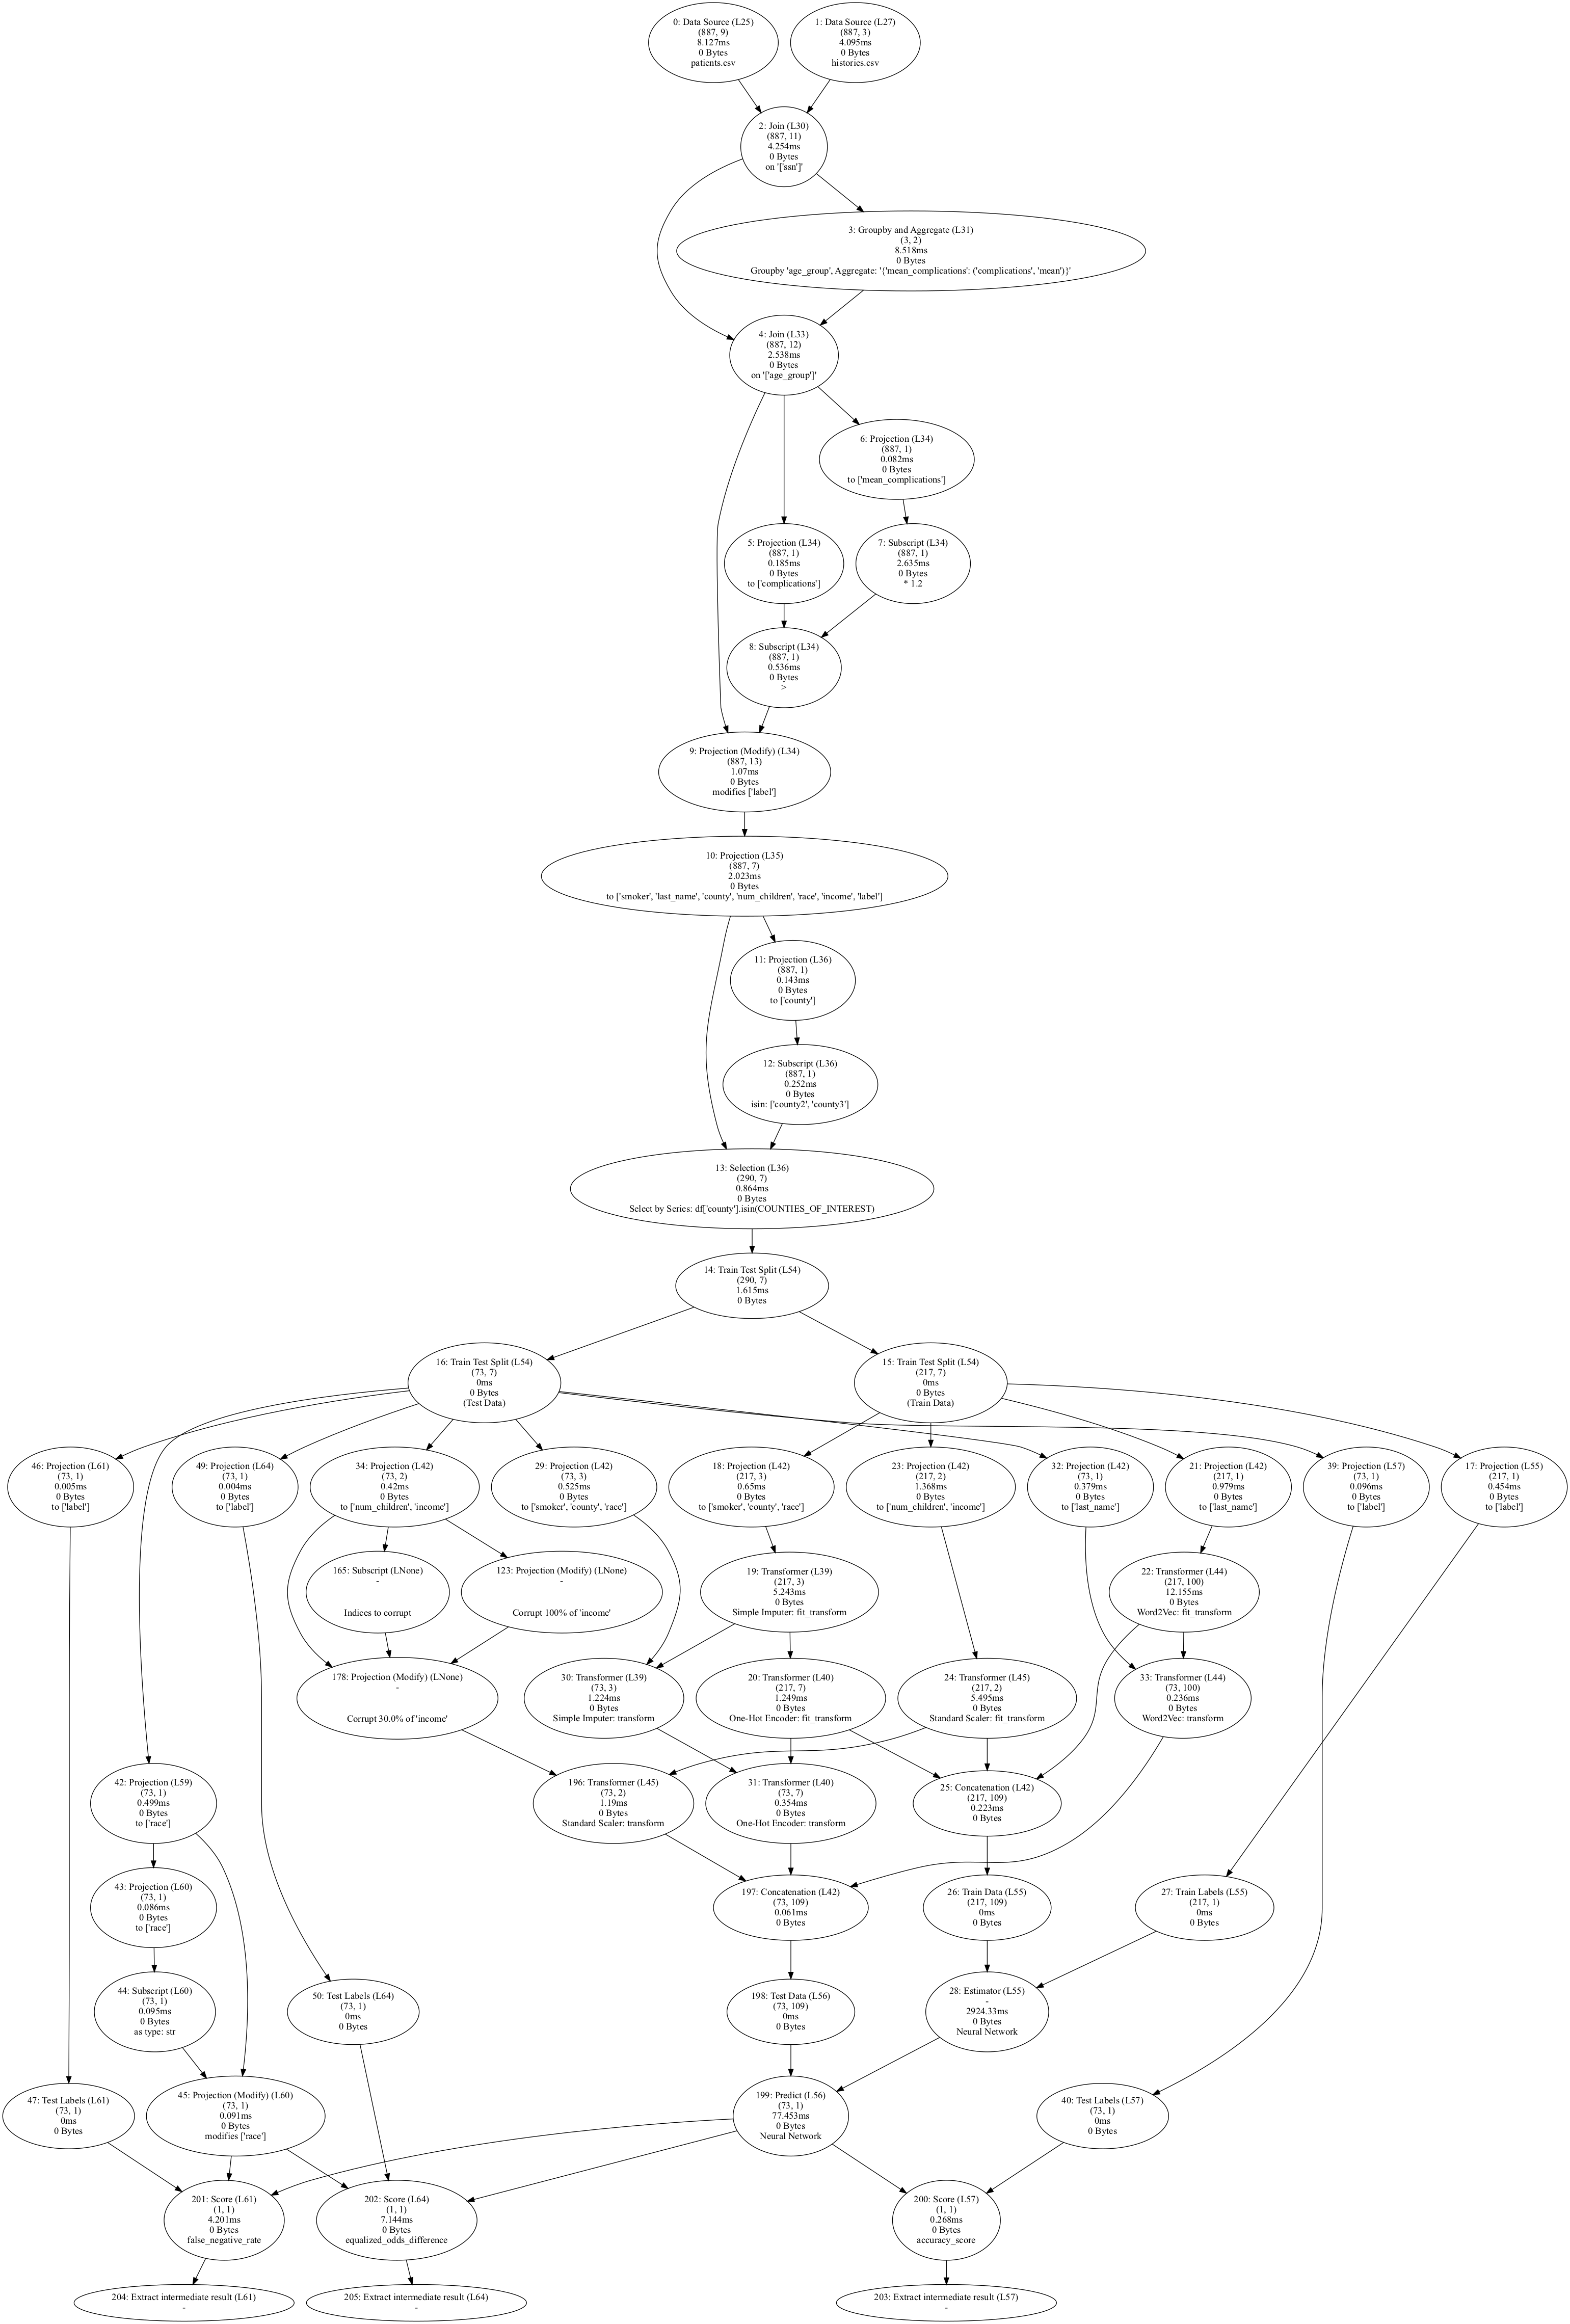

In [5]:
Image(filename=f"{CORRUPTION_INTERMEDIATE_EXTRACTION_GENERATED_PATH}-0.png")

We then use a multi-query optimizer to combine all the generated DAGs for efficient execution.

In [6]:
Image(filename=f"{CORRUPTION_INTERMEDIATE_EXTRACTION_OPTIMISED_PATH}.png")

Let us take a look at how long our analysis takes without this multi-query optimizer.

In [7]:
analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(True) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .execute()

Let us now look at a scenario where we only need to introduce corruptions in the test set, where we do not have model retraining that we cannot optimise away. We can compare without query optimisation...

In [8]:
test_only_data_corruption = DataCorruption([('income', CorruptionType.SCALING),
                                  ('num_children', CorruptionType.MISSING_VALUES)],
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=False)

fast_analysis_result_unopt = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(True) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(test_only_data_corruption) \
    .execute()

NameError: name 'corruption' is not defined

... and with query optimisation.

In [ ]:
fast_analysis_result_opt = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(False) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(test_only_data_corruption) \
    .execute()

The results from the optimised and unoptimised execution are the same, only the randomness involved in model training, which are also present when re-executing the same pipeline multiple times, might lead to minor differences.

In [ ]:
fast_report_opt = fast_analysis_result_opt.analysis_to_result_reports[test_only_data_corruption]
fast_report_opt

In [ ]:
fast_report_unopt = fast_analysis_result_unopt.analysis_to_result_reports[test_only_data_corruption]
fast_report_unopt

# Operator Fairness
Next, we will look at the `OperatorFairness` what-if analysis.

In [ ]:
from mlwhatif.analysis._operator_impact import OperatorImpact

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(OperatorImpact(True, True)) \
    .execute()

report = analysis_result.analysis_to_result_reports[OperatorImpact(True, True)]
report

In [ ]:
OP_FAIRNESS_INTERMEDIATE_EXTRACTION_ORIG_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                 "operator_fairness-orig")
OP_FAIRNESS_INTERMEDIATE_EXTRACTION_GENERATED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "operator_fairness-what-if")
OP_FAIRNESS_INTERMEDIATE_EXTRACTION_OPTIMISED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "operator_fairness-what-if-optimised")

analysis_result.save_original_dag_to_path(OP_FAIRNESS_INTERMEDIATE_EXTRACTION_ORIG_PATH)
analysis_result.save_what_if_dags_to_path(OP_FAIRNESS_INTERMEDIATE_EXTRACTION_GENERATED_PATH)
analysis_result.save_optimised_what_if_dags_to_path(OP_FAIRNESS_INTERMEDIATE_EXTRACTION_OPTIMISED_PATH)

First, the original pipeline DAG.

In [ ]:
Image(filename=f"{OP_FAIRNESS_INTERMEDIATE_EXTRACTION_ORIG_PATH}.png")

The DAG where we test the StandardScaling.

In [ ]:
Image(filename=f"{OP_FAIRNESS_INTERMEDIATE_EXTRACTION_GENERATED_PATH}-OperatorFairness-2.png")

The DAG where we test the filter.

In [ ]:
Image(filename=f"{OP_FAIRNESS_INTERMEDIATE_EXTRACTION_GENERATED_PATH}-OperatorFairness-3.png")

The optimised DAG.

In [ ]:
Image(filename=f"{OP_FAIRNESS_INTERMEDIATE_EXTRACTION_OPTIMISED_PATH}.png")

# Data Cleaning
Next, we will look at the `DataCleaning` what-if analysis.

In [ ]:
from mlwhatif.analysis._data_cleaning import DataCleaning, ErrorType

data_cleaning = DataCleaning({'smoker': ErrorType.CAT_MISSING_VALUES,
                                  'num_children': ErrorType.NUM_MISSING_VALUES,
                                  'income': ErrorType.OUTLIERS,
                                  'ssn': ErrorType.DUPLICATES,
                                  None: ErrorType.MISLABEL})

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_cleaning) \
    .execute()

report = analysis_result.analysis_to_result_reports[data_cleaning]
report

In [ ]:
CLEANING_INTERMEDIATE_EXTRACTION_ORIG_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                 "operator_fairness-orig")
CLEANING_INTERMEDIATE_EXTRACTION_GENERATED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "operator_fairness-what-if")
CLEANING_INTERMEDIATE_EXTRACTION_OPTIMISED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "operator_fairness-what-if-optimised")

analysis_result.save_original_dag_to_path(CLEANING_INTERMEDIATE_EXTRACTION_ORIG_PATH)
analysis_result.save_what_if_dags_to_path(CLEANING_INTERMEDIATE_EXTRACTION_GENERATED_PATH)
analysis_result.save_optimised_what_if_dags_to_path(CLEANING_INTERMEDIATE_EXTRACTION_OPTIMISED_PATH)